<a href="https://colab.research.google.com/github/sujin-create/hodlhodl/blob/Price-Prediction/Bitcoin%20price%20prediction%20using%20four%20models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import packages

In [ ]:
# 파이업비트 가상화폐 데이터 모듈
!pip install pyupbit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 112 kB 49.8 MB/s 


In [ ]:
import pyupbit
import pandas as pd
import time
import datetime

In [ ]:
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
# import pybithumb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, LSTM, InputLayer
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.ensemble import AdaBoostRegressor

# Data Preprocessing

In [ ]:
ticker = "KRW-BTC"

In [ ]:
# mydf = pyupbit.get_ohlcv(ticker, interval="day", count=3650) # count=200(default)
# mydf = pyupbit.get_ohlcv(ticker, interval="minute60", count = 36500).reset_index() # count=200(default)
mydf = pyupbit.get_ohlcv(ticker, interval="day", count = 3650).reset_index() # count=200(default)
mydf
# 업비트에서 제공하는 모든 데이터 출력함 (5년치)

,index,open,high,low,close,volume,value
0,2017-09-25 09:00:00+00:00,4201000.0,4333000.0,4175000.0,4322000.0,132.484755,5.602146e+08
1,2017-09-26 09:00:00+00:00,4317000.0,4418000.0,4311000.0,4321000.0,22.788340,9.950724e+07
2,2017-09-27 09:00:00+00:00,4322000.0,4677000.0,4318000.0,4657000.0,32.269662,1.448276e+08
3,2017-09-28 09:00:00+00:00,4657000.0,4772000.0,4519000.0,4586000.0,80.588243,3.721860e+08
4,2017-09-29 09:00:00+00:00,4586000.0,4709000.0,4476000.0,4657000.0,59.352373,2.724558e+08
...,...,...,...,...,...,...,...
1706,2022-05-28 09:00:00+00:00,36862000.0,37373000.0,36613000.0,37034000.0,1931.845973,7.136116e+10
1707,2022-05-29 09:00:00+00:00,37033000.0,37620000.0,36825000.0,37380000.0,1712.650146,6.369122e+10
1708,2022-05-30 09:00:00+00:00,37415000.0,39989000.0,37230000.0,39550000.0,5467.460037,2.112747e+11
1709,2022-05-31 09:00:00+00:00,39527000.0,40600000.0,39300000.0,39923000.0,6442.979981,2.563085e+11


In [ ]:
plt.rcParams["figure.figsize"] = (15,10)

Text(0.5, 1.0, 'ETH')

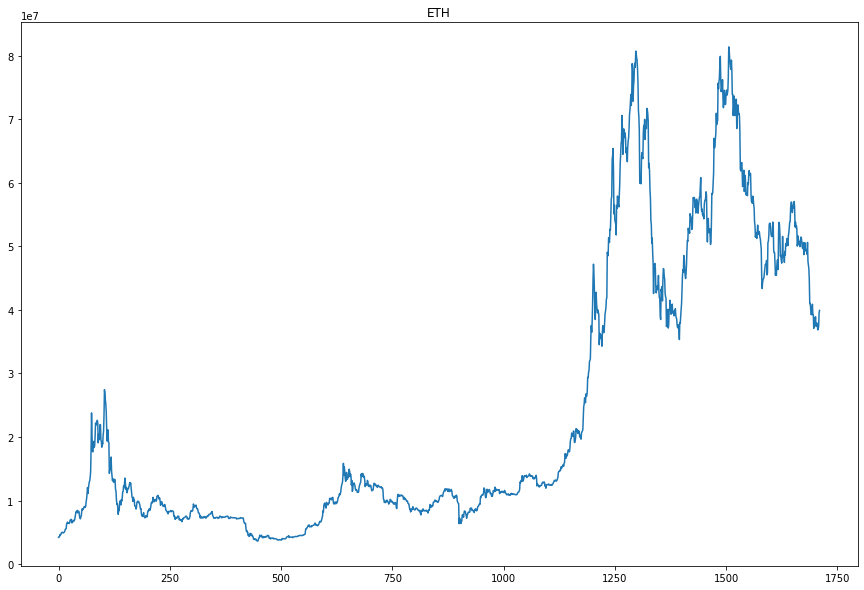

In [ ]:
plt.plot(mydf['open'])
plt.title('ETH')

In [ ]:
def preprocess(series, window_size=None, scaling=True):

    if window_size!=None:
        series = series.rolling(window_size, min_periods=0).mean()
    array = np.array(series)
    
    if scaling==True:
        scaler = MinMaxScaler()
        training_data = scaler.fit_transform(array.reshape(-1,1))
    else:
        scaler = None

    return training_data, scaler

In [ ]:
def make_dataset(training_data, t, h=0, test_size=0.2):
    
    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [ ]:
training_data, scaler = preprocess(mydf['open'], window_size=10)

In [ ]:
X_train,X_test,y_train,y_test = make_dataset(training_data, t = 168)

# MAE, MSE, RMSE
### 시계열 데이터 예측 모델의 성능을 평가하는 지표

In [ ]:
def MAE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.abs(y_true-y_pred)))

def MSE(y_true, y_pred):
    return "{:.2e}".format(np.mean(np.square(y_true-y_pred)))

def RMSE(y_true, y_pred):
    return "{:.2e}".format(np.sqrt(np.mean(np.square(y_true-y_pred))))

# **GRU-adaboost FIT**

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
# adaboost
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=50, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  


In [ ]:
final_model.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Epoch 1/50
42/42 [==============================] - 11s 12ms/step - loss: 0.0087
Epoch 2/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 3/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 4/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0013
Epoch 5/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 6/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 7/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0014
Epoch 8/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0010
Epoch 9/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 10/50
42/42 [==============================] - 0s 8ms/step - loss: 0.0011
Epoch 11/50
42/42 [==============================] - 0s 8ms/step - loss: 9.9994e-04
Epoch 12/50
42/42 [==============================] - 0s 8ms/step - loss: 8.8384e-04
Epoch 13/50
42/42 [====================

AdaBoostRegressor(base_estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f72701742d0>,
                  n_estimators=5, random_state=42)

In [ ]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

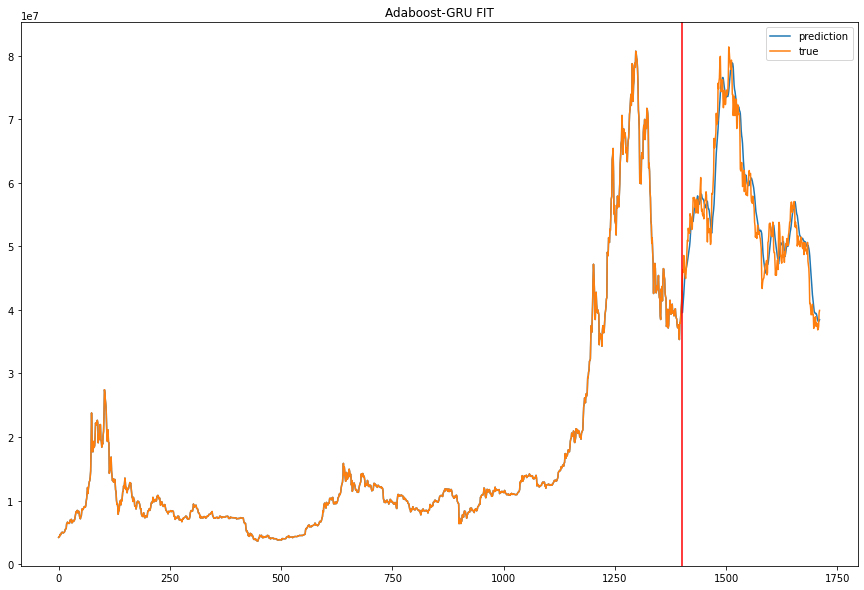

In [ ]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-GRU FIT')
plt.show()

In [ ]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

2.46e+06
9.61e+12
3.10e+06


# **LSTM-adaboost FIT**

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
LSTM_Predictors = KerasRegressor(build_fn=lambda:model, epochs=50, batch_size=30)
final_model = AdaBoostRegressor(LSTM_Predictors, n_estimators=5, random_state=42)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  """Entry point for launching an IPython kernel.


In [ ]:
final_model.fit(X_train,y_train)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


42/42 [==============================] - 8s 137ms/step - loss: 0.0109
Epoch 2/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0026
Epoch 3/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0022
Epoch 4/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0017
Epoch 5/50
42/42 [==============================] - 6s 137ms/step - loss: 0.0013
Epoch 6/50
42/42 [==============================] - 6s 137ms/step - loss: 0.0017
Epoch 7/50
42/42 [==============================] - 6s 136ms/step - loss: 0.0015
Epoch 8/50
42/42 [==============================] - 6s 136ms/step - loss: 0.0012
Epoch 9/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0013
Epoch 10/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0010
Epoch 11/50
42/42 [==============================] - 6s 138ms/step - loss: 0.0010
Epoch 12/50
42/42 [==============================] - 6s 137ms/step - loss: 0.0012
Epoch 13/50
42/42 [=================

In [ ]:
preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

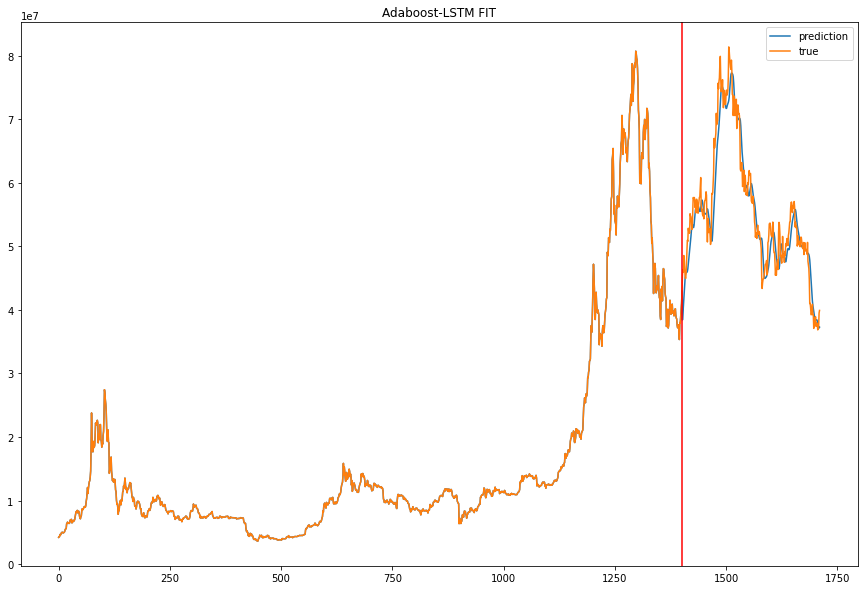

In [ ]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('Adaboost-LSTM FIT')
plt.show()

In [ ]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

2.49e+06
1.06e+13
3.26e+06


# **GRU FIT**

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train,y_train,batch_size=30,epochs=50,validation_split=0.2)

Epoch 1/50
33/33 [==============================] - 2s 25ms/step - loss: 0.0011 - val_loss: 0.0087
Epoch 2/50
33/33 [==============================] - 0s 9ms/step - loss: 1.3379e-04 - val_loss: 0.0016
Epoch 3/50
33/33 [==============================] - 0s 10ms/step - loss: 1.0113e-04 - val_loss: 0.0011
Epoch 4/50
33/33 [==============================] - 0s 9ms/step - loss: 1.0543e-04 - val_loss: 8.3735e-04
Epoch 5/50
33/33 [==============================] - 0s 9ms/step - loss: 8.9554e-05 - val_loss: 0.0013
Epoch 6/50
33/33 [==============================] - 0s 9ms/step - loss: 8.8060e-05 - val_loss: 6.6024e-04
Epoch 7/50
33/33 [==============================] - 0s 9ms/step - loss: 7.2851e-05 - val_loss: 0.0018
Epoch 8/50
33/33 [==============================] - 0s 9ms/step - loss: 7.1220e-05 - val_loss: 6.1148e-04
Epoch 9/50
33/33 [==============================] - 0s 9ms/step - loss: 6.0231e-05 - val_loss: 5.6156e-04
Epoch 10/50
33/33 [==============================] - 0s 9ms/step - l

In [ ]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

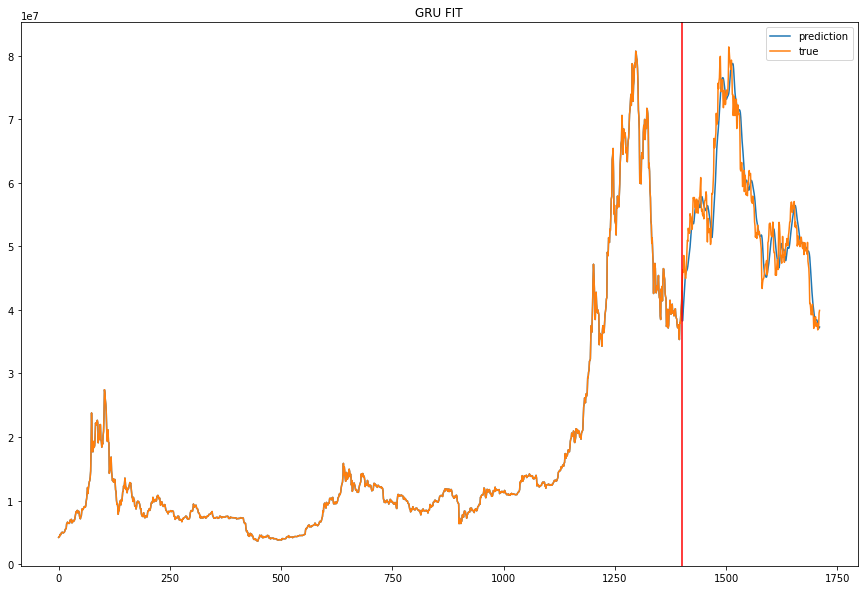

In [ ]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('GRU FIT')
plt.show()

In [ ]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

2.60e+06
1.11e+13
3.33e+06


# **LSTM FIT**

In [ ]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))

In [ ]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.fit(X_train,y_train,batch_size=30,epochs=50,validation_split=0.2)

Epoch 1/50
33/33 [==============================] - 2s 26ms/step - loss: 9.8300e-04 - val_loss: 0.0095
Epoch 2/50
33/33 [==============================] - 0s 10ms/step - loss: 1.6659e-04 - val_loss: 0.0026
Epoch 3/50
33/33 [==============================] - 0s 11ms/step - loss: 1.3658e-04 - val_loss: 0.0025
Epoch 4/50
33/33 [==============================] - 0s 10ms/step - loss: 1.2158e-04 - val_loss: 0.0022
Epoch 5/50
33/33 [==============================] - 0s 11ms/step - loss: 1.0655e-04 - val_loss: 0.0018
Epoch 6/50
33/33 [==============================] - 0s 10ms/step - loss: 8.6816e-05 - val_loss: 0.0019
Epoch 7/50
33/33 [==============================] - 0s 10ms/step - loss: 8.9642e-05 - val_loss: 0.0015
Epoch 8/50
33/33 [==============================] - 0s 10ms/step - loss: 9.3072e-05 - val_loss: 0.0023
Epoch 9/50
33/33 [==============================] - 0s 11ms/step - loss: 8.8148e-05 - val_loss: 0.0017
Epoch 10/50
33/33 [==============================] - 0s 11ms/step - loss:

In [ ]:
preds = model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([mydf['open'][:-len(preds)], preds.squeeze(1)])

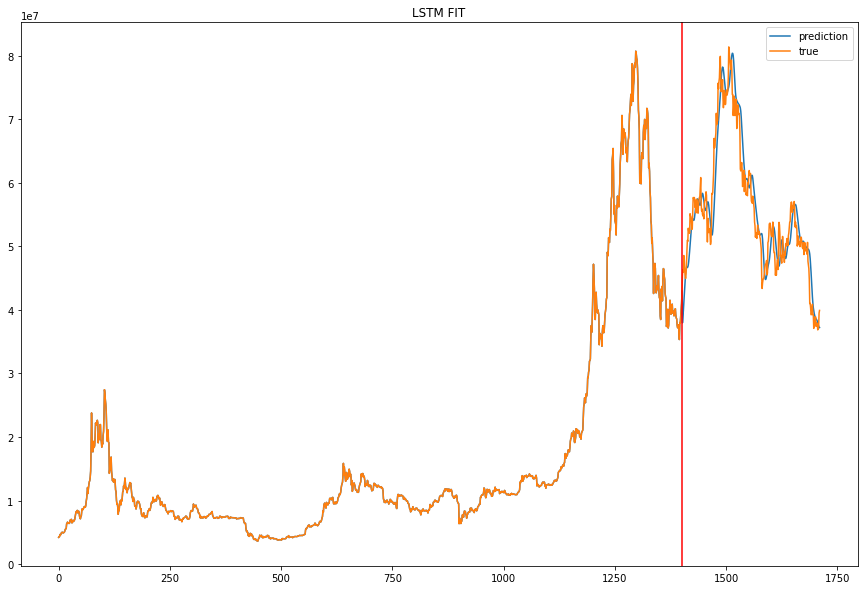

In [ ]:
plt.plot(preds_series, label='prediction')
plt.plot(mydf['open'], label='true')
plt.axvline(x=len(mydf['open'])-len(preds), color='r')
plt.legend()
plt.title('LSTM FIT')
plt.show()


In [ ]:
y_true = mydf['open'][-len(preds):]
y_pred = preds.squeeze(1)

In [ ]:
print(MAE(y_true, y_pred))
print(MSE(y_true, y_pred))
print(RMSE(y_true, y_pred))

2.81e+06
1.28e+13
3.58e+06
